<h1><center> <font color='black'> Business Data Analytics - Practice Session_07 </font></center></h1>
<h2><center> <font color='black'> Recommendation Systems</font></center></h3>
<h2><center> <font color='black'> University of Tartu - Spring 2020</font></center></h3>

## Introduction

**<font size="2">Recommendation Systems:** is one of the most famous applications of data science and machine learning that provides help and support for bussiness companies.
    
    
   * <font size="2">Have you ever wondered how **Netflix** suggests movies to you based on the movies you have already watched? Or how does an **e-commerce** websites display options such as "Frequently Bought Together"? They may look relatively simple options but behind the scenes, a complex statistical algorithm executes in order to predict these recommendations. **Such systems are called Recommender Systems, Recommendation Systems, or Recommendation Engines.**
    
    
   * <font size="2">A **Recommender System** employs a statistical algorithm that seeks to predict users' ratings for a particular entity, based on the **similarity between the items** or **similarity between users** that previously rated those entities. The intuition is that similar types of users are likely to have similar ratings for a set of entities.


   * <font size="2">Currently, many of the big tech companies out there use a Recommender System in one way or another. You can find them anywhere from:
       * Amazon (product recommendations)
       * YouTube (video recommendations)
       * Facebook (friend recommendations).
       

## Types of Recommender Systems:


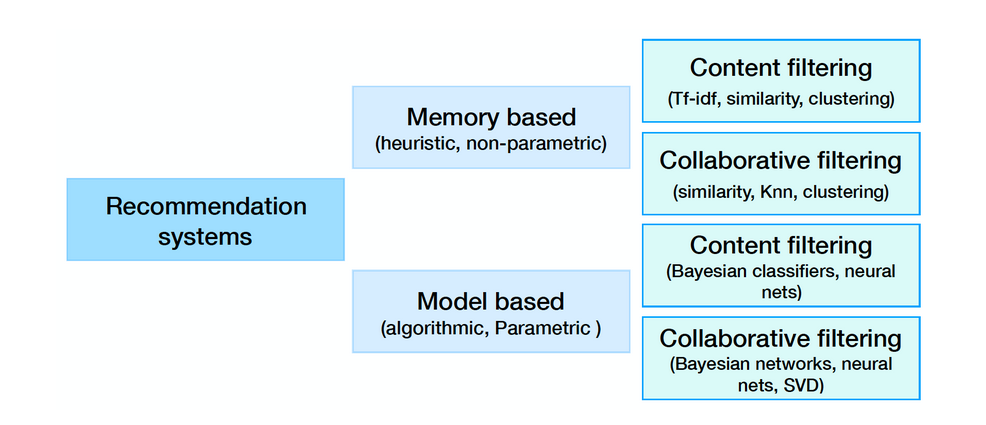

In [0]:
from IPython.display import Image
Image(filename='rec2.png') 

<font size="2">In today's practice session we will talk about **Collaborative Filtering**, and **content filtering**
    
    


1. <font size="2">**Collaborative Filtering (CF):** This type of filter is based on users’ rates, and it will recommend us movies that we haven’t watched yet, but users similar to us have, and like. `But how can we determine the similarirty between users?` To determine whether two users are similar or not, this filter considers the movies both of them watched and how they rated them.
    
    * We have two different types of **CF**: 
        * <font size="2">**User-Based Collaborative Filtering (UB-CF)**
        * <font size="2">**Item-Based Collaborative Filtering (IB-CF):**



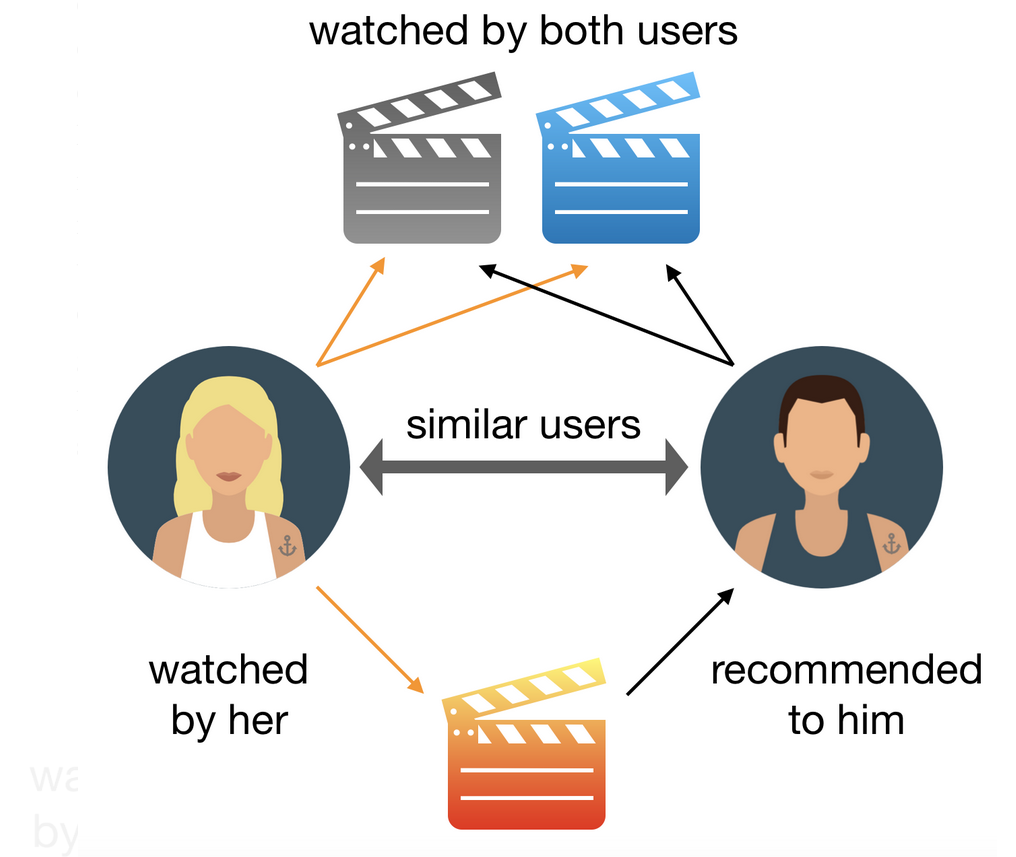

In [0]:
from IPython.display import Image
Image(filename='colab.png') 
# source: https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243

<font size="2">**User-Based Collaborative Filtering (UB-CF):**  by following the magic rule which is "similar people will have similar behavior" we can build a recommendation system based on users similarity. We will create a **User-Item Matrix** predicting the ratings on items the active user has not see, based on the other similar users.
    
<font size="2">**Item-Based Collaborative Filtering (IB-CF):**   Instead of tracing user's behavior, we will focus on the behavior or similarity between items. We have tow different tasks to do in this type:
        
   * Calculate similarity among the items.
   * Calculation of Prediction.



## Item-Based Collaborative Filtering (IB-CF):

## Data Sets
We will use [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/).
This dataset (ml-latest.zip) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 27753444 ratings and 1108997 tag applications across 58098 movies. These data were created by 283228 users between January 09, 1995 and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files  `movies.csv`, `ratings.csv` and `tags.csv`.


## Lab Session Content
1. Collaborative Filtering (CF) - Item based Collaborative Filtering (IB-CF):
    * Exploratory data analysis
    * Train KNN model for item-based collaborative filtering
    * Use this trained model to make movie recommendations to myself
    
2. content filtering:
   

In [0]:
!pip install fuzzywuzzy

In [0]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [0]:
import pandas as pd


####  Load Data

In [0]:
movies_filename = 'movies.csv'
ratings_filename = 'ratings.csv'

# read movies data set and set data types for a set of coulmns
df_movies = pd.read_csv((movies_filename),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

# read rating data set and set data types for a set of coulmns
df_ratings = pd.read_csv((ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [0]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 2 columns):
movieId    9125 non-null int32
title      9125 non-null object
dtypes: int32(1), object(1)
memory usage: 107.1+ KB


In [0]:
df_ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [0]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
userId     100004 non-null int32
movieId    100004 non-null int32
rating     100004 non-null float32
dtypes: float32(1), int32(2)
memory usage: 1.1 MB


In [0]:
# get unique users and movies from data sets
num_users = len(df_ratings.userId.unique())  # unique users
num_items = len(df_ratings.movieId.unique()) # unique items (movies)
print('There are "{}" unique users\nand "{}" unique movies in this data set'.format(num_users, num_items))

There are "671" unique users
and "9066" unique movies in this data set


### 1.1. Exploratory data analysis
 - Plot the counts of each rating
 - Plot rating frequency of each movie

#### 1.1.1.  Plot the counts of each rating
we first need to get the counts of each rating from ratings data

In [0]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1101
1.0,3326
1.5,1687
2.0,7271
2.5,4449
3.0,20064
3.5,10538
4.0,28750
4.5,7723


We can see that above table does not include counts of zero rating score. So we need to add that in rating count dataframe as well

In [0]:
# there are a lot more counts in rating of zero

# get total count based on the number of users and the number of items
total_cnt = num_users * num_items


rating_zero_cnt = total_cnt - df_ratings.shape[0]

# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
).sort_index()


df_ratings_cnt

,count
0.0,5983282
0.5,1101
1.0,3326
1.5,1687
2.0,7271
2.5,4449
3.0,20064
3.5,10538
4.0,28750
4.5,7723


The count for zero rating score is too big to compare with others. So let's take log transform for count values and then we can plot them to compare

In [0]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5983282,15.604480
0.5,1101,7.003974
1.0,3326,8.109526
1.5,1687,7.430707
2.0,7271,8.891649
2.5,4449,8.400435
3.0,20064,9.906682
3.5,10538,9.262743
4.0,28750,10.266393
4.5,7723,8.951958


Text(0, 0.5, 'number of ratings')

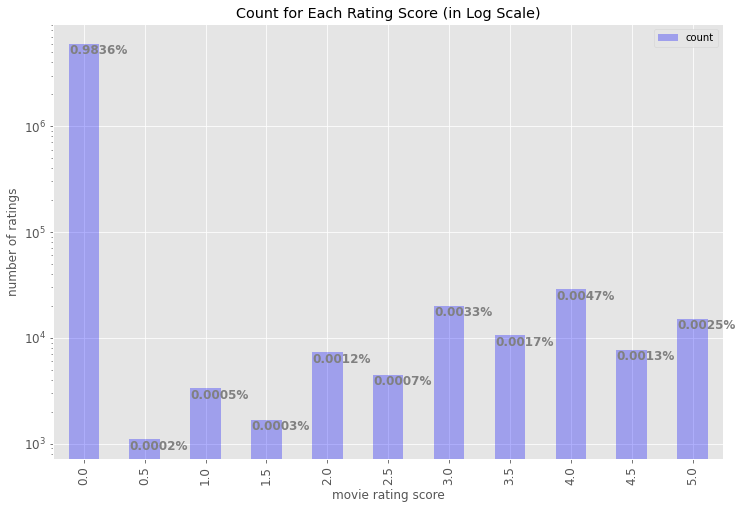

In [0]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
    color='b',
    alpha=0.3
)

totals=[]
for i in ax.patches:
    totals.append(i.get_height())

# # #print(totals)

# set individual bar lables using above list
total = sum(totals)

# create a list to collect the plt.patches data
# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{str(round((p.get_height()/total), 4))}%', (p.get_x()+.012*width, p.get_y()+.8*height),
                color = 'gray',
               weight = 'bold',
               size = 12)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

#### 1.1.2  Plot rating frequency of all movies

In [0]:
df_ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [12]:
# get rating frequency for each movie
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,247
2,107
3,59
4,13
5,56


Text(0, 0.5, 'number of ratings')

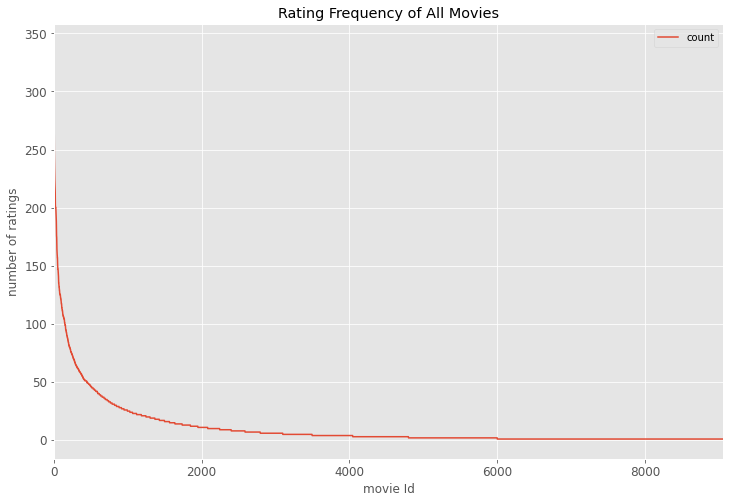

In [0]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

The distribution of ratings among movies often satisfies a property in real-world settings,
which is referred to as the long-tail property. According to this property, only a small
fraction of the items are rated frequently. Such items are referred to as popular items. The
vast majority of items are rated rarely. This results in a highly skewed distribution of the
underlying ratings.

Let's plot the same distribution but with log scale

Text(0, 0.5, 'number of ratings (log scale)')

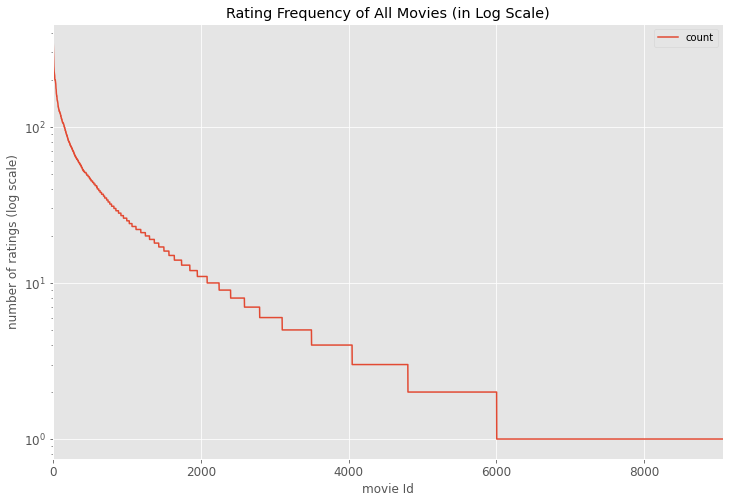

In [0]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

We can see that roughly 1000 out of 53,889 movies are rated more than 100 times. More interestingly, roughly 2000 out of 53,889 movies are rated less than only 10 times. Let's look closer by displaying top quantiles of rating counts

Since we have so many movies, we'll limit it to the top 25%. `This is arbitrary threshold for popularity`, but it gives us lees number of different movies. We still have pretty good amount of movies for modeling. There are two reasons why we want to filter our dataset.
 - `Memory issue:` we don't want to run into the “MemoryError” during model training
 - `Improve KNN performance:` lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality

In [16]:
# filter data base on the popularity threshold
popularity_thres = 50

# get movies that have been rated more than 50 times
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))

# creat new df so that it contains only the popular movies
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100004, 3)
shape of ratings data after dropping unpopular movies:  (43083, 3)


In [17]:
df_ratings_drop_movies.head()

,userId,movieId,rating
8,1,1339,3.5
16,1,2294,2.0
19,1,3671,3.0
20,2,10,4.0
21,2,17,5.0


After dropping 56% of movies in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data

In [18]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,3
2,56
3,30
4,106
5,76


Text(0, 0.5, 'number of ratings')

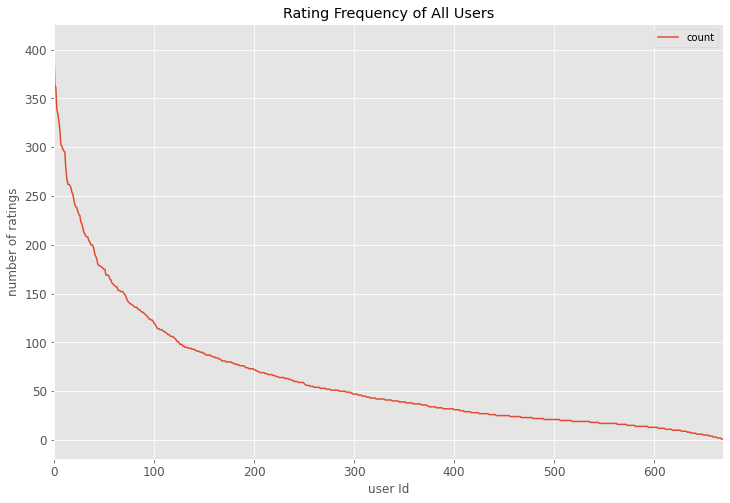

In [0]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

We can see that the distribution of ratings by users is very similar to the distribution of ratings among movies. They both have long-tail property. Only a very small fraction of users are very actively engaged with rating movies that they watched. Vast majority of users aren't interested in rating movies. So we can limit users to the top 40%.

In [19]:
# filter users based on if they active or not
ratings_thres = 50

# active_users: who did rating more than 50 times
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))

# new df after droppin non active users
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]


print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping movies: ', df_ratings_drop_movies.shape)

print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100004, 3)
shape of ratings data after dropping movies:  (43083, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (34044, 3)


In [0]:
df_ratings_drop_users.head()

,userId,movieId,rating
20,2,10,4.0
21,2,17,5.0
22,2,39,5.0
23,2,47,4.0
24,2,50,4.0


## 2. Train KNN model for item-based collaborative filtering:


* Collaborative Filtering Using `k-Nearest Neighbors (kNN)`: **K-NN** is a machine learning algorithm to find clusters of similar items based on user ratings, and make predictions using the average rating of top-k nearest neighbors. For example, we first present ratings in a matrix with the matrix having one row for each item (movie) and one column for each user, so we need to do two things:

 - Reshaping the Data
 - Fitting the Model
 
 
#### 2.1. Reshaping the Data
For `K-Nearest Neighbors`, we want the data to be in an `(movie, user)` array, where each row is a movie and each column is a different user. 

* To reshape the dataframe:
    * We'll pivot the dataframe to the wide format with movies as rows and users as columns. 
    * Then we'll fill the missing observations with 0s since we're going to be performing linear algebra operations (calculating distances between vectors). 
    * Finally, we transform the values of the dataframe into a scipy `sparse matrix` for more efficient calculations.

In [0]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_mat.head()

userId,2,4,5,7,8,15,17,19,20,21,22,23,26,30,34,36,41,42,43,48,56,57,59,61,63,67,68,69,72,73,75,77,78,83,84,85,86,88,89,91,...,570,574,575,577,580,582,584,585,587,590,592,593,594,595,596,597,598,602,603,605,607,608,615,620,623,624,626,627,641,646,647,648,649,654,655,659,662,664,665,671
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,3.0,0.0,2.0,0.0,3.0,3.5,0.0,0.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,5.0,3.0,4.0,5.0,3.5,5.0,3.0,4.0,0.0,0.0,3.5,0.0,3.0,0.0,5.0,5.0,...,1.5,4.0,3.0,5.0,4.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,4.0,5.0,3.5,5.0,4.5,0.0,4.0,0.0,4.5,4.0,4.0,0.0,4.5,5.0,0.0,0.0,4.0,5.0,4.0,0.0,4.0,5.0,0.0,0.0,0.0,3.5,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.5,0.0,0.0,3.5,0.0,0.0,0.0,3.5,0.0,0.0,3.0,3.5,2.5,2.5,0.0,0.0,3.5,0.0,0.0,5.0,0.0,3.5,0.0,0.0,...,0.0,0.0,4.0,0.0,3.5,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,5.0,0.0,3.0,0.0
3,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.5,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
5,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0
6,0.0,0.0,0.0,0.0,0.0,4.0,4.5,3.0,0.0,0.0,0.0,3.5,0.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.5,0.0,3.5,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,4.0,3.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,3.5,0.0,0.0,0.0,0.0,4.0,4.0,0.0,4.0,4.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0


In [0]:
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)
print(f"Sparse matrix:\n{movie_user_mat_sparse}")

Sparse matrix:
  (0, 3)	3.0
  (0, 5)	2.0
  (0, 7)	3.0
  (0, 8)	3.5
  (0, 11)	3.0
  (0, 12)	5.0
  (0, 13)	4.0
  (0, 18)	4.0
  (0, 19)	4.0
  (0, 20)	4.0
  (0, 24)	5.0
  (0, 25)	3.0
  (0, 26)	4.0
  (0, 27)	5.0
  (0, 28)	3.5
  (0, 29)	5.0
  (0, 30)	3.0
  (0, 31)	4.0
  (0, 34)	3.5
  (0, 36)	3.0
  (0, 38)	5.0
  (0, 39)	5.0
  (0, 40)	5.0
  (0, 41)	4.0
  (0, 42)	4.0
  :	:
  (452, 184)	5.0
  (452, 186)	3.0
  (452, 188)	4.5
  (452, 191)	2.5
  (452, 197)	4.0
  (452, 199)	3.0
  (452, 205)	3.0
  (452, 208)	3.0
  (452, 209)	5.0
  (452, 210)	5.0
  (452, 211)	4.0
  (452, 212)	3.5
  (452, 213)	3.5
  (452, 218)	5.0
  (452, 228)	3.5
  (452, 233)	3.5
  (452, 239)	4.0
  (452, 240)	4.0
  (452, 243)	4.0
  (452, 249)	4.0
  (452, 256)	3.5
  (452, 274)	4.0
  (452, 277)	4.0
  (452, 286)	2.0
  (452, 289)	5.0


In [0]:
# create mapper from movie title to index
# movie: index
movie_to_idx = {
    movie: i for i, movie in enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
movie_to_idx


{'10 Things I Hate About You (1999)': 302,
 '12 Angry Men (1957)': 174,
 '2001: A Space Odyssey (1968)': 144,
 '28 Days Later (2002)': 406,
 '300 (2007)': 439,
 '40-Year-Old Virgin, The (2005)': 429,
 'A.I. Artificial Intelligence (2001)': 375,
 'About a Boy (2002)': 388,
 'Abyss, The (1989)': 163,
 'Ace Ventura: Pet Detective (1994)': 62,
 'Ace Ventura: When Nature Calls (1995)': 10,
 'Addams Family Values (1993)': 74,
 'African Queen, The (1951)': 146,
 'Air Force One (1997)': 239,
 'Airplane! (1980)': 320,
 'Aladdin (1992)': 103,
 'Alien (1979)': 181,
 'Aliens (1986)': 172,
 'Alien³ (a.k.a. Alien 3) (1992)': 212,
 'Almost Famous (2000)': 358,
 'Amadeus (1984)': 187,
 "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)": 380,
 'American Beauty (1999)': 323,
 'American History X (1998)': 288,
 'American Pie (1999)': 314,
 'American President, The (1995)': 7,
 'American Psycho (2000)': 348,
 'Analyze This (1999)': 298,
 'Animal House (1978)': 343,
 'Annie Hall (1977)': 189,
 'Antz (1

#### 2.2 Fitting the Model
Time to implement the model. We'll initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. By specifying the `metric = cosine,` the model will measure similarity bectween movies vectors by using cosine similarity.

In [0]:
# define model: using cosine for similarity 
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# fit the model
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

## 4. Use this trained model to make movie recommendations
And we're finally ready to make some recommendations!

In [0]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
            
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in reversed(list(enumerate(raw_recommends))):
        #j =i
        print('{0}: {1}, with distance of {2}'.format(n_recommendations-i, reverse_mapper[idx], dist))
        

In [0]:
my_favorite = 'Iron Man' # Avatar

make_recommendation(
    model_knn=model_knn, # trained model (model)
    data=movie_user_mat_sparse, # sparse matrix (data)
    fav_movie=my_favorite, # fav_movie
    mapper=movie_to_idx, # {movie: index} (mapper)
    n_recommendations=5) 

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Dark Knight, The (2008), with distance of 0.15683269500732422
2: Star Trek (2009), with distance of 0.2591555118560791
3: Batman Begins (2005), with distance of 0.29355061054229736
4: Inception (2010), with distance of 0.32166117429733276
5: WALL·E (2008), with distance of 0.3232719898223877


**5.Evaluation of the Recommender System**

In [21]:
#!pip install surprise
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import Dataset
from surprise import SVD
from surprise import NormalPredictor
from surprise import KNNBasic

# The reader is necessary for surprise to interpret the ratings
reader = Reader(rating_scale=(0, 5))

# This function loads data from a pandas dataframe into surprise dataset structure
# The columns should always be ordered like this
data = Dataset.load_from_df(df_ratings_drop_users[['userId', 'movieId', 'rating']], reader)

# Split in trainset and testset
# No need to define the label y because for surprise the last column is always the rating
trainset, testset = train_test_split(data, test_size=.25, random_state=0 )

knn = KNNBasic()
knn.fit(trainset)
predictions = knn.test(testset)
print('KNN RMSE', accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8818
KNN RMSE 0.8818255417754615


======================================================================================================================

## Part 2: Content-Based Filtering: 

1. This type of filter does not involve other users if not ourselves. Based on what we like, the algorithm will simply pick items with similar content to recommend us.



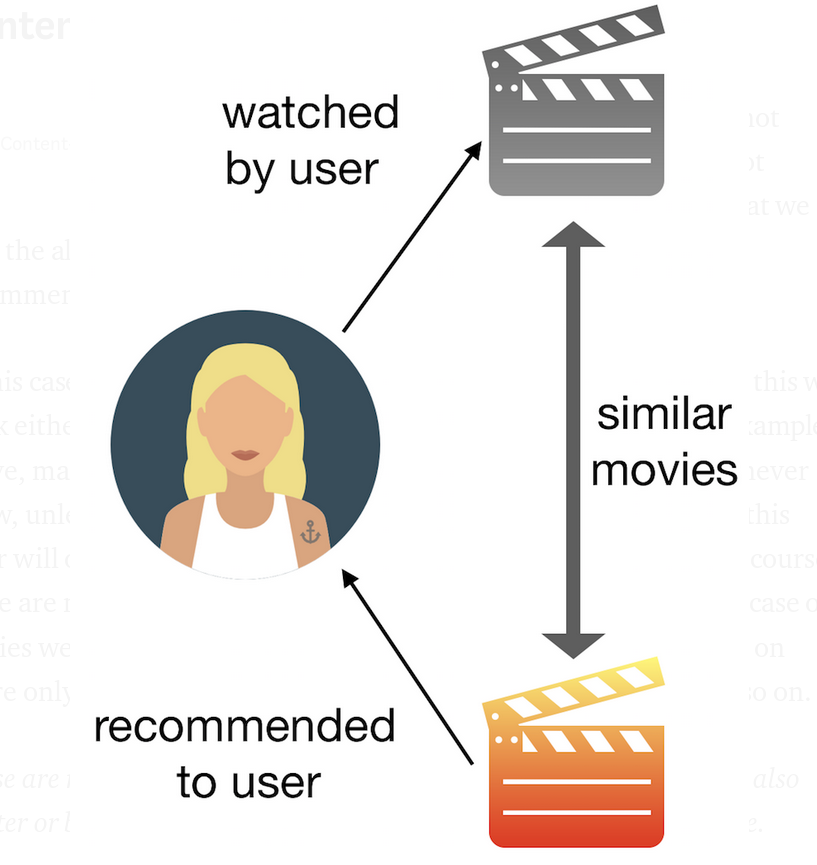

In [0]:
from IPython.display import Image
Image(filename='cbf.png')

In [0]:
# https://heartbeat.fritz.ai/recommender-systems-with-python-part-i-content-based-filtering-5df4940bd831

#### <font size="2">How do content-based recommender systems work?
    
    
1. **Content-based recommenders:** suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.


2. <font size="2">`A content-based recommender` works with data that the user provides, either **explicitly (rating)** or **implicitly (clicking on a link)**. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on those recommendations, the engine becomes more and more accurate.
    
    

#### Movies dataset

In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("movie_dataset.csv")

features = ['keywords','cast','genres','director']

# get each row as a string
def combine_features(row):
    return row['keywords'] +" "+row['cast']+" "+row["genres"]+" "+row["director"]


for feature in features:    
    df[feature] = df[feature].fillna('')
    

df["combined_features"] = df.apply(combine_features,axis=1)
df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director,combined_features
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron,culture clash future space war space colony so...
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski,ocean drug abuse exotic island east india trad...
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes,spy based on novel secret agent sequel mi6 Dan...
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan,dc comics crime fighter terrorist secret ident...
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton,based on novel mars medallion space travel pri...


* Word Counts with `CountVectorizer`:
    * The CountVectorizer provides a simple way to both `tokenize a collection of text documents and build a vocabulary of known words,` but also to encode new documents using that vocabulary.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = CountVectorizer()
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.toarray())

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [0]:
cv = CountVectorizer()

count_matrix = cv.fit_transform(df["combined_features"])

print(cv.get_feature_names())
print(count_matrix.toarray())
#print(count_matrix)

['11', '15th', '17th', '18th', '1910s', '1917', '1920s', '1930s', '1950s', '1960s', '1970s', '1980s', '1990s', '1992', '1995', '19th', '2001', '2002', '3d', '40', '50', '51', '60s', '66', 'aaliyah', 'aamir', 'aaran', 'aarniokoski', 'aaron', 'aasheekaa', 'aasif', 'abai', 'abandoned', 'abascal', 'abbas', 'abbass', 'abbey', 'abbie', 'abbott', 'abdalla', 'abdoo', 'abduction', 'abdul', 'abdulayev', 'abdullah', 'abe', 'abel', 'abell', 'abercrombie', 'abernathy', 'abhinay', 'abhishek', 'abi', 'abigail', 'abiteboul', 'abkarian', 'able', 'abo', 'abraham', 'abrahams', 'abrahamson', 'abrams', 'abramsohn', 'abroad', 'abu', 'abuse', 'abusive', 'academy', 'accent', 'accepting', 'accident', 'accidental', 'accountant', 'accusal', 'accusations', 'accused', 'ace', 'acharya', 'achrekar', 'acinapura', 'acker', 'ackland', 'ackles', 'ackman', 'acovone', 'acres', 'action', 'activism', 'activist', 'actor', 'actors', 'actress', 'ad', 'ada', 'adam', 'adams', 'adamson', 'adaptation', 'adar', 'addict', 'addicted'

In [0]:
cosine_sim = cosine_similarity(count_matrix)
cosine_sim


array([[1.        , 0.10540926, 0.12038585, ..., 0.        , 0.        ,
        0.        ],
       [0.10540926, 1.        , 0.0761387 , ..., 0.03651484, 0.        ,
        0.        ],
       [0.12038585, 0.0761387 , 1.        , ..., 0.        , 0.11145564,
        0.        ],
       ...,
       [0.        , 0.03651484, 0.        , ..., 1.        , 0.        ,
        0.04264014],
       [0.        , 0.        , 0.11145564, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.04264014, 0.        ,
        1.        ]])

In [0]:
def get_title_from_index(index):
    return df[df.index == index]["title"].values[0]

def get_index_from_title(title):
    return df[df.title == title]["index"].values[0]

movie_user_likes = "Iron Man"

movie_index = get_index_from_title(movie_user_likes)
similar_movies =  list(enumerate(cosine_sim[movie_index]))

sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]
i=0
print("Top 5 similar movies to "+movie_user_likes+" are:\n")
for element in sorted_similar_movies:
    print(get_title_from_index(element[0]))
    i=i+1
    if i>=5:
        break

Top 5 similar movies to Iron Man are:

Iron Man 2
Iron Man 3
Avengers: Age of Ultron
The Avengers
Captain America: Civil War
